<a href="https://colab.research.google.com/github/iamharkirat/BMI598/blob/main/p4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [53]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Conv1D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.regularizers import l2
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the data

In [39]:
df=pd.read_csv('/content/drive/MyDrive/bmi598/P4/data.csv')

In [40]:
df.head()

,Label,ax,ay,az,gx,gy,gz,mx,my,mz
0,Left,-0.05,-1.00,-0.13,0.43,0.49,-0.73,-6.95,66.22,-10.52
1,Left,-0.05,-1.00,-0.13,-0.49,0.12,-1.16,-6.80,66.87,-10.23
2,Left,-0.05,-0.99,-0.12,-0.06,-0.12,-0.98,-6.80,66.87,-10.23
3,Left,-0.05,-1.01,-0.12,1.10,-0.12,-0.37,-7.36,66.36,-10.46
4,Left,-0.05,-1.01,-0.12,0.92,-0.24,-1.22,-6.53,66.38,-10.27


## Evaluate the data

In [41]:
print(df.head())
print(df.info())
print(df['Label'].unique())
print(df['Label'].value_counts())


  Label    ax    ay    az    gx    gy    gz    mx     my     mz
0  Left -0.05 -1.00 -0.13  0.43  0.49 -0.73 -6.95  66.22 -10.52
1  Left -0.05 -1.00 -0.13 -0.49  0.12 -1.16 -6.80  66.87 -10.23
2  Left -0.05 -0.99 -0.12 -0.06 -0.12 -0.98 -6.80  66.87 -10.23
3  Left -0.05 -1.01 -0.12  1.10 -0.12 -0.37 -7.36  66.36 -10.46
4  Left -0.05 -1.01 -0.12  0.92 -0.24 -1.22 -6.53  66.38 -10.27
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24416 entries, 0 to 24415
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Label   24416 non-null  object 
 1   ax      24416 non-null  float64
 2   ay      24416 non-null  float64
 3   az      24416 non-null  float64
 4   gx      24416 non-null  float64
 5   gy      24416 non-null  float64
 6   gz      24415 non-null  float64
 7   mx      24415 non-null  float64
 8   my      24415 non-null  float64
 9   mz      24415 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB
None
['Left

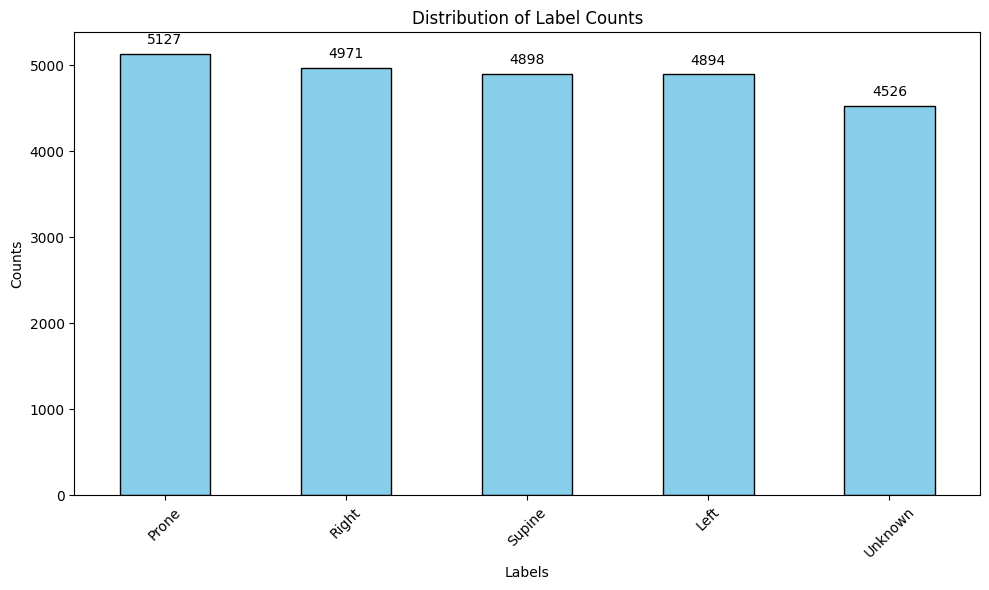

In [42]:
# Plotting
plt.figure(figsize=(10,6))
ax = df['Label'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Label Counts')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=45)

# Adding numbers on top of bars
for p in ax.patches:
    ax.annotate(str(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

In [43]:
df.isnull().sum()

Label    0
ax       0
ay       0
az       0
gx       0
gy       0
gz       1
mx       1
my       1
mz       1
dtype: int64

In [44]:
df = df.dropna()

In [45]:
df.isnull().sum()

Label    0
ax       0
ay       0
az       0
gx       0
gy       0
gz       0
mx       0
my       0
mz       0
dtype: int64

## Sliding window function

In [46]:
def sliding_window(data, labels, window_size, step_size):
    num_windows = (data.shape[0] - window_size) // step_size + 1
    X = np.array([data[i:i+window_size] for i in range(0, num_windows * step_size, step_size)])

    # Assuming the label remains the same for the entire window (common for time-series classification tasks)
    y = np.array([labels[i] for i in range(0, num_windows * step_size, step_size)])

    return X, y


In [47]:
def normalize_data(df):
    """This function will normalize the data excluding the label."""
    scaler = StandardScaler()
    # Exclude the 'Label' column for normalization
    columns_to_normalize = df.columns.difference(['Label'])
    # Apply normalization and convert back to DataFrame
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df

In [48]:
# Shuffle and balance each subset of labels separately
supine_df = df[df['Label'] == 'Supine'].sample(frac=1).reset_index(drop=True)
left_df = df[df['Label'] == 'Left'].sample(frac=1).reset_index(drop=True)
right_df = df[df['Label'] == 'Right'].sample(frac=1).reset_index(drop=True)
prone_df = df[df['Label'] == 'Prone'].sample(frac=1).reset_index(drop=True)
unknown_df = df[df['Label'] == 'Unknown'].sample(frac=1).reset_index(drop=True)

# Apply the normalization
supine_df = normalize_data(supine_df)
left_df = normalize_data(left_df)
right_df = normalize_data(right_df)
prone_df = normalize_data(prone_df)
unknown_df = normalize_data(unknown_df)

# Assuming your data is sampled at 50Hz
f = 50
window_size = 2*f
step_size = window_size

# Apply the sliding window function to each subset
X_supine, y_supine = sliding_window(supine_df.drop('Label', axis=1).values.astype(float), supine_df['Label'].values, window_size, step_size)
X_left, y_left = sliding_window(left_df.drop('Label', axis=1).values.astype(float), left_df['Label'].values, window_size, step_size)
X_right, y_right = sliding_window(right_df.drop('Label', axis=1).values.astype(float), right_df['Label'].values, window_size, step_size)
X_prone, y_prone = sliding_window(prone_df.drop('Label', axis=1).values.astype(float), prone_df['Label'].values, window_size, step_size)
X_unknown, y_unknown = sliding_window(unknown_df.drop('Label', axis=1).values.astype(float), unknown_df['Label'].values, window_size, step_size)


# Combine the subsets
X_segments = np.concatenate([X_supine, X_left, X_right, X_prone, X_unknown])
y_segments = np.concatenate([y_supine, y_left, y_right, y_prone, y_unknown])

# Shuffle the entire dataset
indices = np.arange(X_segments.shape[0])
np.random.shuffle(indices)
X_segments = X_segments[indices]
y_segments = y_segments[indices]

# Convert labels to integers using LabelEncoder
label_encoder = LabelEncoder()
y_segments = label_encoder.fit_transform(y_segments)

## Split data into train & test set

In [49]:
# Splitting dataset into Train and Test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_segments, y_segments, test_size=0.3, stratify=y_segments, random_state=42)

In [50]:
y_test

array([1, 4, 1, 4, 2, 0, 1, 3, 0, 0, 4, 2, 0, 2, 0, 2, 3, 2, 0, 0, 1, 3,
       2, 3, 4, 1, 3, 4, 0, 2, 4, 0, 2, 3, 2, 4, 3, 0, 1, 1, 0, 2, 4, 3,
       2, 4, 1, 2, 2, 3, 4, 0, 3, 0, 0, 1, 3, 4, 2, 1, 4, 3, 1, 4, 4, 1,
       1, 1, 0, 1, 3, 2, 3])

In [57]:
from tensorflow.keras.utils import to_categorical
# One-hot encode labels
y_train_one_hot = to_categorical(y_train, num_classes=5)
y_test_one_hot = to_categorical(y_test, num_classes=5)

In [58]:
y_test_one_hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0.

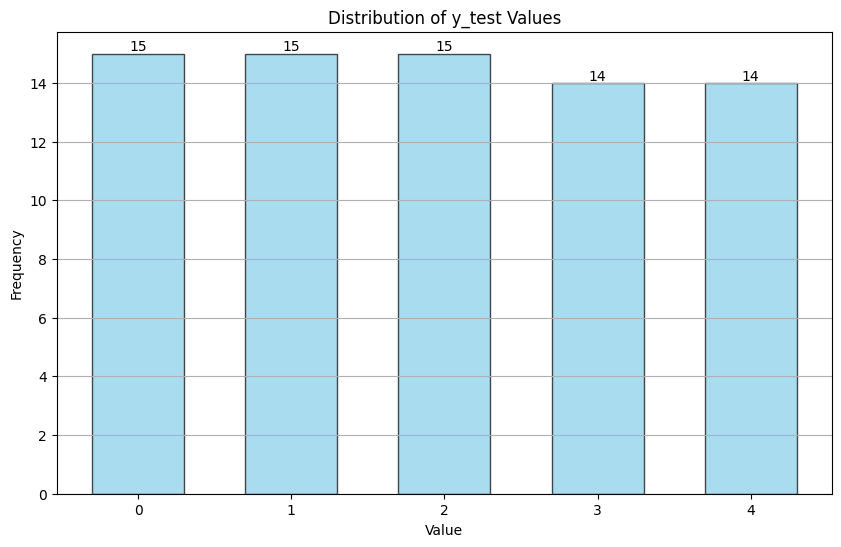

In [29]:
(unique, counts) = np.unique(y_test, return_counts=True)

plt.figure(figsize=(10,6))
plt.bar(unique, counts, width=0.6, edgecolor='black', color='skyblue', alpha=0.7)
plt.title('Distribution of y_test Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(range(5))
plt.grid(axis='y')

# Adding numbers on top of bars
for i, value in enumerate(unique):
    plt.text(value, counts[i], str(counts[i]), ha='center', va='bottom', fontsize=10)

plt.show()

# Build the model

## conv1d

Epoch 1/200
3/3 [==============================] - 5s 177ms/step - loss: 2.9684 - accuracy: 0.2560 - val_loss: 2.2126 - val_accuracy: 0.2603
Epoch 2/200
3/3 [==============================] - 0s 40ms/step - loss: 1.6223 - accuracy: 0.6190 - val_loss: 2.1884 - val_accuracy: 0.2877
Epoch 3/200
3/3 [==============================] - 0s 39ms/step - loss: 1.1470 - accuracy: 0.7976 - val_loss: 2.1449 - val_accuracy: 0.4247
Epoch 4/200
3/3 [==============================] - 0s 38ms/step - loss: 0.9016 - accuracy: 0.9167 - val_loss: 2.0945 - val_accuracy: 0.4521
Epoch 5/200
3/3 [==============================] - 0s 42ms/step - loss: 0.7735 - accuracy: 0.9762 - val_loss: 2.0419 - val_accuracy: 0.5342
Epoch 6/200
3/3 [==============================] - 0s 39ms/step - loss: 0.7066 - accuracy: 0.9881 - val_loss: 1.9914 - val_accuracy: 0.5342
Epoch 7/200
3/3 [==============================] - 0s 46ms/step - loss: 0.6816 - accuracy: 0.9881 - val_loss: 1.9453 - val_accuracy: 0.5753
Epoch 8/200
3/3 [==

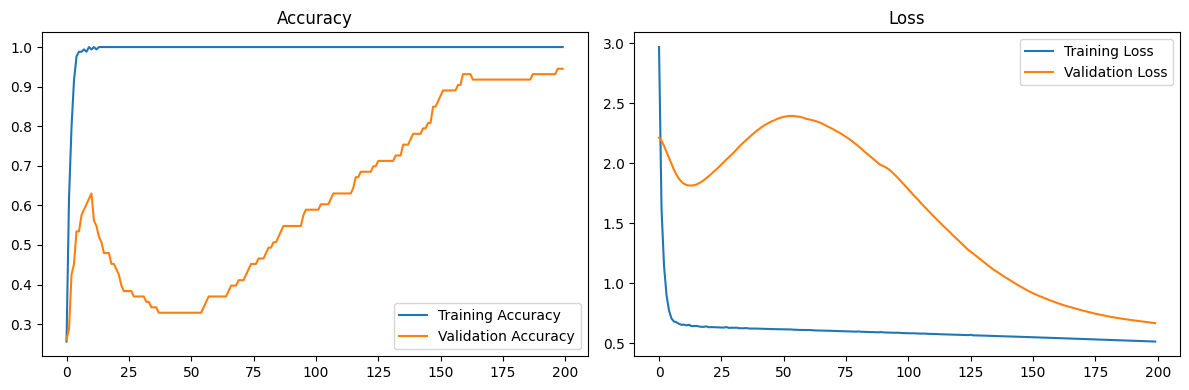

In [66]:
from tensorflow.keras.optimizers import Adamax

# Function to create model
def create_model(activation_function='relu', input_shape=None):
    model = Sequential([
        Conv1D(512, 3, activation=activation_function, kernel_regularizer=l2(0.001), input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Dropout(0.3),
        Conv1D(256, 3, activation=activation_function, kernel_regularizer=l2(0.001), padding='same'),
        BatchNormalization(),
        Dropout(0.3),
        Conv1D(128, 3, activation=activation_function, kernel_regularizer=l2(0.001), padding='same'),
        BatchNormalization(),
        Dropout(0.3),
        Conv1D(64, 3, activation=activation_function, kernel_regularizer=l2(0.001), padding='same'),
        BatchNormalization(),
        Dropout(0.3),
        Flatten(),
        Dense(5, activation='softmax')
    ])
    return model

# Assume X_train, y_train_one_hot, X_test, and y_test_one_hot are pre-defined
input_shape = (X_train.shape[1], X_train.shape[2])

# Model creation and compilation
model = create_model(activation_function='relu', input_shape=input_shape)
# optimizer = Adam(learning_rate=0.1)
# optimizer = RMSprop(learning_rate=0.001)
optimizer = Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model Training
history = model.fit(
    X_train, y_train_one_hot,
    epochs=200,  # Keep this high since we're not using early stopping
    batch_size=64,
    validation_data=(X_test, y_test_one_hot),
)

# Model Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_one_hot, axis=1)

accuracy = accuracy_score(y_true_classes, y_pred_classes)
report = classification_report(y_true_classes, y_pred_classes)

# Results Display
print(f"Accuracy on TEST data with ReLU: {accuracy*100:.2f}%")
print("\nClassification Report for TEST data with ReLU:\n", report)

# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()

In [68]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_72 (Conv1D)          (None, 100, 512)          14336     
                                                                 
 batch_normalization_72 (Ba  (None, 100, 512)          2048      
 tchNormalization)                                               
                                                                 
 dropout_72 (Dropout)        (None, 100, 512)          0         
                                                                 
 conv1d_73 (Conv1D)          (None, 100, 256)          393472    
                                                                 
 batch_normalization_73 (Ba  (None, 100, 256)          1024      
 tchNormalization)                                               
                                                                 
 dropout_73 (Dropout)        (None, 100, 256)        

In [81]:
# Converting one-hot encoded predictions to labels
labels = ['Left', 'Prone', 'Right', 'Supine', 'Unknown']
predicted_labels = [labels[np.argmax(p)] for p in y_pred]
true_labels = [labels[np.argmax(p)] for p in y_test_one_hot]

# Creating a DataFrame
results_df = pd.DataFrame({
    'Predicted': predicted_labels,
    'True': true_labels
})

# Creating a 'Match' column, which is 'Yes' if Predicted and True are the same, otherwise 'No'
results_df['Match'] = np.where(results_df['Predicted'] == results_df['True'], 'Yes', 'No')

# Displaying the DataFrame
results_df.head(20)

,Predicted,True,Match
0,Prone,Prone,Yes
1,Unknown,Unknown,Yes
2,Prone,Prone,Yes
3,Unknown,Unknown,Yes
4,Supine,Right,No
5,Left,Left,Yes
6,Prone,Prone,Yes
7,Supine,Supine,Yes
8,Left,Left,Yes
9,Left,Left,Yes


In [67]:
# Save the model in TensorFlow SavedModel format
model.save("/content/drive/MyDrive/bmi598/P4/adamax_model")


In [69]:
# Convert the model to tflite format
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/bmi598/P4/adamax_model")
tflite_model = converter.convert()

# Save the tflite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)